In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import ast
import glob
import tensorflow as tf
from tensorflow import keras

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline


from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras import layers

plt.style.use('ggplot')
%matplotlib inline

In [3]:
pd.set_option('display.max_columns', 50)

In [4]:
master = pd.read_csv('data/master_cleaned.csv')

In [5]:
comments = pd.read_csv('data/comments.csv', usecols=[0,1,2])

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
dates = pd.read_csv('data/comments_dates.csv', names=['name','url','dates'])

In [7]:
comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19789 entries, 0 to 19788
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  19789 non-null  object
 1   url         19789 non-null  object
 2   comments    19789 non-null  object
dtypes: object(3)
memory usage: 463.9+ KB


In [8]:
comments.drop('Unnamed: 0', axis=1, inplace=True)

In [14]:
comments.head()

,url,comments
0,https://www.kickstarter.com/projects/117862918...,[]
1,https://www.kickstarter.com/projects/lizardsho...,[]
2,https://www.kickstarter.com/projects/184368767...,[]
3,https://www.kickstarter.com/projects/376746530...,[]
4,https://www.kickstarter.com/projects/116371417...,[]


In [15]:
comments['comments'][11] = []
comments['comments'][12] = []

In [16]:
urls = pd.read_csv('data/comments_urls_copy.csv')

In [17]:
urls.head()

,Unnamed: 0,id,name,url
0,0,751419376,Iron Age Kingdoms - First Free To Win Mobile S...,https://www.kickstarter.com/projects/117862918...
1,1,289952460,"""Lizard"" a short film",https://www.kickstarter.com/projects/lizardsho...
2,2,37585826,Total Franchise Football 2016,https://www.kickstarter.com/projects/184368767...
3,3,1727301949,The Trans-American Psychogeographic Literary C...,https://www.kickstarter.com/projects/376746530...
4,4,144196412,The Golden Ticket to the Wonka Factory,https://www.kickstarter.com/projects/116371417...


In [18]:
# merge comments table with url tables to get campaign id
full = pd.merge(urls, comments, how='right', on= 'url', )

In [19]:
full_with_dates = pd.merge(full, dates, on='url')
full_with_dates.drop(columns=['Unnamed: 0', 'name_y'], inplace=True)

In [20]:
full_with_dates.rename(columns={'name_x': 'name'}, inplace=True)


## Merge with Master

In [21]:
# full df with comments and dates
df = pd.merge(master, full_with_dates, on='name')
df.drop(columns=['Unnamed: 0', 'country_displayable_name'], inplace=True)


In [22]:
# master list with outer join, with comments or no comments 
df_full = pd.merge(master, full_with_dates, on='name', how='left')
df_full.drop(columns=['Unnamed: 0','country_displayable_name'], inplace=True)
df_full.shape

(169657, 25)

In [23]:
cols_to_convert = ['deadline', 'launched_at']
for c in cols_to_convert:
    df[c] = pd.to_datetime(df[c])

In [24]:
cols_to_convert = ['deadline', 'launched_at']
for c in cols_to_convert:
    df_full[c] = pd.to_datetime(df_full[c])

In [25]:
df['mid_campaign'] = df['launched_at'] + pd.DateOffset(15)
df['mid_campaign'] = df['mid_campaign'].dt.round('d')
df['dates'] = df['dates'].map(lambda x: x.split("',"))
df['comment_length'] = df['dates'].map(lambda x: len(x))

In [26]:
def extract(cat):
    x = ast.literal_eval(re.search('({.+})', cat).group(0))
    if 'parent_name' not in x.keys():
        return x['slug']
    else:
        return x['parent_name'].lower()

In [27]:
df['category_type'] = df['category'].map(lambda x: extract(x))
df = df[df['state'].isin(['successful', 'failed'])]
df_full['category_type'] = df_full['category'].map(lambda x: extract(x))
df_full = df_full[df_full['state'].isin(['successful', 'failed'])]

In [28]:
print(df.shape)
print(df_full.shape)

(8427, 27)
(169657, 25)


In [29]:
df_full.head()

,backers_count,blurb,category,deadline,goal,launched_at,name,pledged,slug,staff_pick,state,urls,launched_year,launched_month,campaign_length,category_type,blurb_length,country_name,scrape_url,complete_url,scrape_urls,id,url,comments,dates
0,5,A Free to Win Online Mobile Strategy Game to e...,"{""id"":272,""name"":""Mobile Games"",""slug"":""games/...",2017-10-09 14:41:03,1000.0,2017-09-25 14:41:03,Iron Age Kingdoms - First Free To Win Mobile S...,105.0,iron-age-kingdoms-first-free-to-win-mobile-str...,False,failed,"{""web"":{""project"":""https://www.kickstarter.com...",2017,9,14,games,24,Canada,https://www.kickstarter.com/projects/117862918...,https://www.kickstarter.com/projects/117862918...,https://www.kickstarter.com/projects/117862918...,NaN,NaN,NaN,NaN
1,19,"Lizard is a dark comedy and modern western, th...","{""id"":11,""name"":""Film & Video"",""slug"":""film & ...",2019-09-21 23:39:48,1100.0,2019-07-23 23:39:48,"""Lizard"" a short film",2358.0,lizard-a-short-film,False,successful,"{""web"":{""project"":""https://www.kickstarter.com...",2019,7,60,film & video,15,the United States,https://www.kickstarter.com/projects/lizardsho...,https://www.kickstarter.com/projects/lizardsho...,https://www.kickstarter.com/projects/lizardsho...,NaN,NaN,NaN,NaN
2,5,My friend and I are making an app that has nev...,"{""id"":272,""name"":""Mobile Games"",""slug"":""games/...",2016-03-22 21:11:17,25000.0,2016-01-22 22:11:17,Total Franchise Football 2016,172.0,total-franchise-football-2016,False,failed,"{""web"":{""project"":""https://www.kickstarter.com...",2016,1,60,games,25,the United States,https://www.kickstarter.com/projects/184368767...,https://www.kickstarter.com/projects/184368767...,https://www.kickstarter.com/projects/184368767...,NaN,NaN,NaN,NaN
3,23,"More than a bike trip, a state of mind. And a ...","{""id"":48,""name"":""Nonfiction"",""slug"":""publishin...",2012-09-25 02:33:06,500.0,2012-09-15 02:33:06,The Trans-American Psychogeographic Literary C...,501.0,the-trans-american-psychogeographic-literary-c...,False,successful,"{""web"":{""project"":""https://www.kickstarter.com...",2012,9,10,publishing,12,the United States,https://www.kickstarter.com/projects/376746530...,https://www.kickstarter.com/projects/376746530...,https://www.kickstarter.com/projects/376746530...,NaN,NaN,NaN,NaN
4,0,This is the birth of a revolutionary artist......,"{""id"":39,""name"":""Hip-Hop"",""slug"":""music/hip-ho...",2017-12-11 02:43:11,2500.0,2017-11-10 02:43:11,The Golden Ticket to the Wonka Factory,0.0,the-golden-ticket-to-the-wonka-factory,False,failed,"{""web"":{""project"":""https://www.kickstarter.com...",2017,11,31,music,23,the United States,https://www.kickstarter.com/projects/116371417...,https://www.kickstarter.com/projects/116371417...,https://www.kickstarter.com/projects/116371417...,NaN,NaN,NaN,NaN


In [30]:
def to_date(x):
    lst = []
    for i in x:
        i = i.replace("[", '').replace("]", '')
        d = pd.to_datetime(i[:-4])
        lst.append(d)
    return lst

In [31]:
df['dates'] = df['dates'].map(lambda x: to_date(x))

In [32]:
def date_subtract(df):
    lst = []
    for index, row in df.iterrows():
        row_lst =[]
        r = row['dates']
        for i in r:
            if i < row['mid_campaign']:
                row_lst.append(i)
        lst.append(row_lst)
    return lst 

In [33]:
def real_comments(df):
    lst = []
    for index, row in df.iterrows():
        r = eval(row['comments'])
        a = row['pre_mid_campaign_dates_length']
        if a > 0:
            lst.append(r[-a:])
        else:
            lst.append([])
    return lst

In [34]:
def have_comments(x):
    if x > 0:
        return 1
    else:
        return 0

In [35]:
df['pre_mid_campaign_dates'] = date_subtract(df)
df['pre_mid_campaign_dates_length'] = df['pre_mid_campaign_dates'].apply(lambda x: len(x))
df['have_comments'] = df['pre_mid_campaign_dates_length'].apply(lambda x: have_comments(x))

In [36]:
df['pre_mid_campaign_comments'] = real_comments(df)

In [37]:
df.head()

,backers_count,blurb,category,deadline,goal,launched_at,name,pledged,slug,staff_pick,state,urls,launched_year,launched_month,campaign_length,category_type,blurb_length,country_name,scrape_url,complete_url,scrape_urls,id,url,comments,dates,mid_campaign,comment_length,pre_mid_campaign_dates,pre_mid_campaign_dates_length,have_comments,pre_mid_campaign_comments
0,152,A photography and poetry book featuring contem...,"{""id"":278,""name"":""People"",""slug"":""photography/...",2017-05-28 17:00:00,15000.0,2017-05-03 16:57:18,Burma Storybook,15777.00,burma-storybook,True,successful,"{""web"":{""project"":""https://www.kickstarter.com...",2017,5,25,photography,13,the Netherlands,https://www.kickstarter.com/projects/618155130...,https://www.kickstarter.com/projects/618155130...,https://www.kickstarter.com/projects/618155130...,1.769794e+09,https://www.kickstarter.com/projects/618155130...,['Oh! My! The book has arrived and I am speech...,"[2017-06-30 10:52:00, 2017-05-26 03:53:00]",2017-05-19,2,[],0,0,[]
1,116,100 sumie ink originals by David Mack on top o...,"{""id"":276,""name"":""Fine Art"",""slug"":""photograph...",2018-07-29 21:05:01,8000.0,2018-06-29 21:05:01,The Alchemy of Collaboration,16706.00,the-alchemy-of-collaboration,False,successful,"{""web"":{""project"":""https://www.kickstarter.com...",2018,6,30,photography,21,the United States,https://www.kickstarter.com/projects/punchgrap...,https://www.kickstarter.com/projects/punchgrap...,https://www.kickstarter.com/projects/punchgrap...,5.263051e+08,https://www.kickstarter.com/projects/punchgrap...,"[""I know you read the messages. I've been chas...","[2020-06-01 10:55:00, 2020-05-21 09:46:00, 202...",2018-07-15,21,[],0,0,[]
2,50,"8 artists explore the collision of art, the en...","{""id"":54,""name"":""Mixed Media"",""slug"":""art/mixe...",2012-06-04 03:59:00,3300.0,2012-05-03 12:13:56,Frack This? - The Wyoming Artist Expedition,3805.00,frack-this-the-wyoming-artist-expedition,False,successful,"{""web"":{""project"":""https://www.kickstarter.com...",2012,5,32,art,16,the United States,https://www.kickstarter.com/projects/331530956...,https://www.kickstarter.com/projects/331530956...,https://www.kickstarter.com/projects/331530956...,1.103726e+09,https://www.kickstarter.com/projects/331530956...,"['To the Artists:', 'I encourage each artist t...","[2012-05-30 15:37:00, 2012-05-14 14:46:00, 201...",2012-05-19,4,"[2012-05-14 14:46:00, 2012-05-12 09:48:00, 201...",3,1,"[Lori, the kids will want you and Uncle Michae..."
3,8,Cookietownworld is an interactive website desi...,"{""id"":272,""name"":""Mobile Games"",""slug"":""games/...",2016-08-07 16:15:57,95000.0,2016-06-08 16:15:57,Cookietownworld,3229.00,cookietownworld,False,failed,"{""web"":{""project"":""https://www.kickstarter.com...",2016,6,60,games,13,the United States,https://www.kickstarter.com/projects/cookietow...,https://www.kickstarter.com/projects/cookietow...,https://www.kickstarter.com/projects/cookietow...,2.045995e+09,https://www.kickstarter.com/projects/cookietow...,['I think Cookietownworld is an awesome idea. ...,[2016-06-23 08:55:00],2016-06-24,1,[2016-06-23 08:55:00],1,1,[I think Cookietownworld is an awesome idea. I...
4,59,Explore a magical world full of monsters and d...,"{""id"":272,""name"":""Mobile Games"",""slug"":""games/...",2017-12-22 20:25:20,15000.0,2017-11-22 20:25:20,Dunpets Colors: Monster-catching RPG,4310.75,dunpets-colors-dungeon-crawl-and-pets,True,failed,"{""web"":{""project"":""https://www.kickstarter.com...",2017,11,30,games,22,Spain,https://www.kickstarter.com/projects/gugamesde...,https://www.kickstarter.com/projects/gugamesde...,https://www.kickstarter.com/projects/gugamesde...,1.228293e+09,https://www.kickstarter.com/projects/gugamesde...,"['Any updates about the premier? :)', 'Any pro...","[2018-04-17 18:49:00, 2018-01-22 01:59:00, 201...",2017-12-08,18,"[2017-12-03 12:14:00, 2017-12-03 07:10:00, 201...",11,1,"[Any progress update on the premiere?, Sorry t..."


In [38]:
eval(df['comments'][2])[-3:]

['Lori, the kids will want you and Uncle Michael to sign their card!  Enjoy your trip.',
 'My $25 pledge was on behalf of Nina Gibbons, who donated to support this project.  Thanks so much for your donation.',
 'Hope you guys have a great trip! My only request-my brother and Lori have to sign my book!']

In [39]:
df_filtered = df[['name', 'have_comments']].copy()

In [40]:
df_master = pd.merge(df_full, df_filtered, on='name', how='left')
df_master = df_master[df_master['state'].isin(['successful', 'failed'])]
df_master['category_type'] = df_master['category'].map(lambda x: extract(x))
df_master['have_comments'].fillna(0, inplace=True)

In [41]:
df_master['have_comments'].value_counts()

0.0    165838
1.0      4411
Name: have_comments, dtype: int64

## One Hot Encoding 

In [42]:
df_master_ohe = pd.get_dummies(df_master[['category_type', 'country_name', 'staff_pick']])

In [44]:
data = pd.merge(df_master, df_master_ohe, left_index=True, right_index=True)


In [45]:
good_data = data[data['state'].isin(['successful', 'failed'])]
live = data[data['state'].isin(['live'])]


In [46]:
good_data['state'] = good_data['state'].replace(to_replace=['successful', 'failed'], value=[1,0])

In [47]:
model_data = good_data.copy()

In [48]:
X = model_data.drop(['backers_count','blurb', 'category', 'deadline', 'launched_at', 'urls', 'scrape_url', 'complete_url',
                     'scrape_urls', 'name', 'pledged', 'slug', 'state', 'category_type', 'country_name',
                    'staff_pick_y', 'id', 'url', 'comments', 'dates'],
                   axis=1)
y = model_data['state']


## Scraped Campaigns Only


In [49]:
df_filtered = df[['name', 'have_comments']].copy()

In [50]:
model_data_ = pd.merge(full, df_filtered, on='name', how='left')
model_data_.fillna(0,inplace=True)


In [51]:
model_data1 = pd.merge(data, model_data_, on='name', how='right')

In [52]:
model_data1.fillna(0, inplace=True)
model_data1['state'] = model_data1['state'].replace(to_replace=['successful', 'failed'], value=[1,0])

In [53]:
model_data1.shape

(26779, 57)

In [54]:
model_data1.have_comments_y.value_counts()

0.0    18778
1.0     8001
Name: have_comments_y, dtype: int64

In [55]:
model_data1.groupby(['have_comments_y', 'state']).count()

backers_count  blurb  category  deadline   goal  \
have_comments_y state                                                    
0.0             0               8291   8291      8291      8291   8291   
                1              10487  10487     10487     10487  10487   
1.0             0               1550   1550      1550      1550   1550   
                1               6451   6451      6451      6451   6451   

                       launched_at   name  pledged   slug  staff_pick_x  \
have_comments_y state                                                     
0.0             0             8291   8291     8291   8291          8291   
                1            10487  10487    10487  10487         10487   
1.0             0             1550   1550     1550   1550          1550   
                1             6451   6451     6451   6451          6451   

                        urls  launched_year  launched_month  campaign_length  \
have_comments_y state                                                          
0.0             0       8291           8291            8291             8291   
                1      10487          10487           10487            10487   
1.0             0       1550           1550            1550             1550   
                1       6451           6451            6451             6451   

                       category_type  blurb_length  country_name  scrape_url  \
have_comments_y state                                                          
0.0             0               8291          8291          8291        8291   
                1              10487         10487         10487       10487   
1.0             0               1550          1550          1550        1550   
                1               6451          6451          6451        6451   

                       complete_url  scrape_urls   id_x  url_x  comments_x  \
have_comments_y state                                                        
0.0             0              8291         8291   8291   8291        8291   
                1             10487        10487  10487  10487       10487   
1.0             0              1550         1550   1550   1550        1550   
                1              6451         6451   6451   6451        6451   

                       dates  have_comments_x  ...  category_type_design  \
have_comments_y state                          ...                         
0.0             0       8291             8291  ...                  8291   
                1      10487            10487  ...                 10487   
1.0             0       1550             1550  ...                  1550   
                1       6451             6451  ...                  6451   

                       category_type_fashion  category_type_film & video  \
have_comments_y state                                                      
0.0             0                       8291                        8291   
                1                      10487                       10487   
1.0             0                       1550                        1550   
                1                       6451                        6451   

                       category_type_food  category_type_games  \
have_comments_y state                                            
0.0             0                    8291                 8291   
                1                   10487                10487   
1.0             0                    1550                 1550   
                1                    6451                 6451   

                       category_type_journalism  category_type_music  \
have_comments_y state                                                  
0.0             0                          8291                 8291   
                1                         10487                10487   
1.0             0                          1550                 1550   
                1        

In [56]:
bar_width = 0.25
success = [10487, 6451]
failed = [8291, 1550]

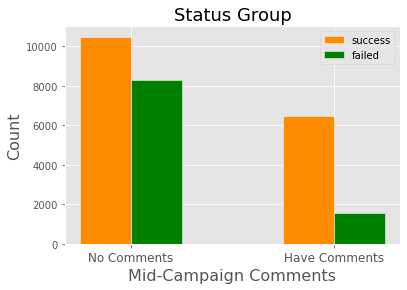

In [57]:
r1 = np.arange(len(success))
r2 = [x + bar_width for x in r1]

plt.bar(r1, success, color='darkorange', width=bar_width, edgecolor='white', label='success')
plt.bar(r2, failed, color='green', width=bar_width, edgecolor='white', label='failed')
plt.xlabel('Mid-Campaign Comments', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xticks([r + bar_width*0.5 for r in range(len(success))], ['No Comments', 'Have Comments'], fontsize=12)
plt.title('Status Group', fontsize=18)
plt.legend()
plt.show()

In [58]:
X1 = model_data1.drop(['backers_count','blurb', 'category', 'deadline', 'urls', 'scrape_url', 'complete_url', 'scrape_urls',
                     'launched_at', 'name', 'pledged', 'slug', 'state', 'category_type', 'country_name', 'id_x', 'url_x',
                       'comments_x', 'dates', 'staff_pick_y', 'Unnamed: 0', 'id_y', 'url_y', 'comments_y', 'have_comments_y'],
                   axis=1)
y1 = model_data1['state']

In [59]:
X1_old = model_data1.drop(['backers_count','blurb', 'category', 'deadline', 'urls', 'scrape_url', 'complete_url', 'scrape_urls',
                     'launched_at', 'name', 'pledged', 'slug', 'state', 'category_type', 'country_name', 'id_x', 'url_x',
                       'comments_x', 'dates', 'staff_pick_y', 'Unnamed: 0', 'id_y', 'url_y', 'comments_y', 'have_comments_y', 
                          'have_comments_x'], axis=1)
y1_old = model_data1['state']

In [60]:
df_filtered2 = df[['name', 'have_comments', 'pre_mid_campaign_dates_length']].copy()

In [61]:
model_data_2 = pd.merge(full, df_filtered2, on='name', how='left')
model_data_2.fillna(0,inplace=True)

In [62]:
model_data2 = pd.merge(data, model_data_2, on='name', how='right')

In [63]:
model_data2.fillna(0, inplace=True)
model_data2['state'] = model_data2['state'].replace(to_replace=['successful', 'failed'], value=[1,0])

In [64]:
X2 = model_data2.drop(['backers_count','blurb', 'category', 'deadline', 'urls', 'scrape_url', 'complete_url', 'scrape_urls',
                     'launched_at', 'name', 'pledged', 'slug', 'state', 'category_type', 'country_name', 'id_x', 'url_x',
                       'comments_x', 'dates', 'staff_pick_y', 'Unnamed: 0', 'id_y', 'url_y', 'comments_y', 'have_comments_y'],
                   axis=1)
y2 = model_data2['state']

## Modeling

In [76]:
## Old model with added "have comments" features. FULL DATASET
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [77]:
def get_scores(classifier, X_train, X_test, y_train, y_test, **kwargs):
    model = classifier(**kwargs)
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    return model.score(X_test, y_test), precision_score(y_test, y_predict), recall_score(y_test, y_predict)
print("Model, Accuracy, Precision, Recall")
print("    Random Forest:", get_scores(RandomForestClassifier, X_train, X_test, y_train, y_test))
print("    Logistic Regression:", get_scores(LogisticRegression, X_train, X_test, y_train, y_test))
print("    Gradient Boost:", get_scores(GradientBoostingClassifier, X_train, X_test, y_train, y_test))

Model, Accuracy, Precision, Recall
    Random Forest: (0.7358033973169185, 0.7582875618402088, 0.7943360809597649)
    Logistic Regression: (0.6240161642741349, 0.619026288529914, 0.9022688321227454)
    Gradient Boost: (0.7401029062801024, 0.7455435417884279, 0.8328572594466661)


In [78]:
## Old model with scraped campaign, no added new comment features.
X_train, X_test, y_train, y_test = train_test_split(X1_old, y1_old)

In [79]:
def get_scores(classifier, X_train, X_test, y_train, y_test, **kwargs):
    model = classifier(**kwargs)
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    return model.score(X_test, y_test), precision_score(y_test, y_predict), recall_score(y_test, y_predict)
print("Model, Accuracy, Precision, Recall")
print("    Random Forest:", get_scores(RandomForestClassifier, X_train, X_test, y_train, y_test))
print("    Logistic Regression:", get_scores(LogisticRegression, X_train, X_test, y_train, y_test))
print("    Gradient Boost:", get_scores(GradientBoostingClassifier, X_train, X_test, y_train, y_test))

Model, Accuracy, Precision, Recall
    Random Forest: (0.810455563853622, 0.8312179915386328, 0.8795947219604147)
    Logistic Regression: (0.6725914861837192, 0.6726691349713901, 0.9418001885014138)
    Gradient Boost: (0.8058252427184466, 0.8205574912891986, 0.8878416588124411)


In [80]:
## Old model with added "have comments" features. 26.8K DATAPOINTS, THOSE THAT ARE SCRAPED
X_train, X_test, y_train, y_test = train_test_split(X1, y1)

In [81]:
def get_scores(classifier, X_train, X_test, y_train, y_test, **kwargs):
    model = classifier(**kwargs)
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    return model.score(X_test, y_test), precision_score(y_test, y_predict), recall_score(y_test, y_predict)
print("Model, Accuracy, Precision, Recall")
print("    Random Forest:", get_scores(RandomForestClassifier, X_train, X_test, y_train, y_test))
print("    Logistic Regression:", get_scores(LogisticRegression, X_train, X_test, y_train, y_test))
print("    Gradient Boost:", get_scores(GradientBoostingClassifier, X_train, X_test, y_train, y_test))

Model, Accuracy, Precision, Recall
    Random Forest: (0.815982076176251, 0.8376030296279795, 0.8820079756040348)
    Logistic Regression: (0.6642270351008215, 0.6714310022120129, 0.9256392212057236)
    Gradient Boost: (0.8150858849887976, 0.8321985504063255, 0.88881069669247)


In [82]:
## Old model with added "have comments" and "pre_mid_campaign_dates_length" features. 26.8K DATAPOINTS, THOSE THAT ARE SCRAPED
X_train, X_test, y_train, y_test = train_test_split(X2, y2)

In [83]:
def get_scores(classifier, X_train, X_test, y_train, y_test, **kwargs):
    model = classifier(**kwargs)
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    return model.score(X_test, y_test), precision_score(y_test, y_predict), recall_score(y_test, y_predict)
print("Model, Accuracy, Precision, Recall")
print("    Random Forest:", get_scores(RandomForestClassifier, X_train, X_test, y_train, y_test))
print("    Logistic Regression:", get_scores(LogisticRegression, X_train, X_test, y_train, y_test))
print("    Gradient Boost:", get_scores(GradientBoostingClassifier, X_train, X_test, y_train, y_test))

Model, Accuracy, Precision, Recall
    Random Forest: (0.8150858849887976, 0.8403607666290868, 0.8754991778247592)


/Users/Helen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


    Logistic Regression: (0.6788648244958925, 0.6831218494698418, 0.923185341789993)
    Gradient Boost: (0.8117998506348021, 0.8311602209944752, 0.8834860230209067)


## LSTM

In [65]:
df_lstm = df[df['pre_mid_campaign_comments'].apply(lambda x: len(x)>2)]


In [66]:

def string_convert(x):
    str1 = ''.join(str(e) for e in x)
    return str1

In [67]:
df_lstm['pre_mid_campaign_comments'] = df_lstm['pre_mid_campaign_comments'].apply(lambda x: string_convert(x))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [68]:
x = df_lstm['pre_mid_campaign_comments'].values

#### Model with 150 keywords

In [ ]:
# tokenizer = Tokenizer(num_words=150)
# maxlen=50
# embedding_dim=100
# model=Sequential()
# model.add(layers.Embedding(input_dim=vocab_size,
#          output_dim=embedding_dim,
#          input_length=maxlen))
# model.add(layers.LSTM(units=50,return_sequences=True))
# model.add(layers.LSTM(units=30))
# model.add(layers.Dropout(0.2))
# model.add(layers.Dense(1, activation="sigmoid"))
# model.compile(optimizer="adam", loss="binary_crossentropy", 
#      metrics=['accuracy'])
# model.summary()


In [64]:
tokenizer = Tokenizer(num_words=150)
tokenizer.fit_on_texts(x)
xtest= tokenizer.texts_to_sequences(x) 
maxlen=50
xtest=pad_sequences(xtest,padding='post', maxlen=maxlen)

In [75]:
print(xtest[0])
print(x[0])

[ 38  63  18  82   6  20  75   8  95  17   4  45  16 103  16   5  17   2
  16  70   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Lori, the kids will want you and Uncle Michael to sign their card!  Enjoy your trip.My $25 pledge was on behalf of Nina Gibbons, who donated to support this project.  Thanks so much for your donation.Hope you guys have a great trip! My only request-my brother and Lori have to sign my book!


In [76]:
vocab_size=len(tokenizer.word_index)+1
vocab_size

24495

In [77]:
model_150 = keras.models.load_model('my_half_model_150')
predict_150 = model_150.predict(xtest)
df_lstm['sentiment_predict'] = predict_150

#### Model with 200 Keywords

In [ ]:
# tokenizer = Tokenizer(num_words=200)
# maxlen=80
# embedding_dim=100
# model=Sequential()
# model.add(layers.Embedding(input_dim=vocab_size,
#          output_dim=embedding_dim,
#          input_length=maxlen))
# model.add(layers.LSTM(units=50,return_sequences=True))
# model.add(layers.LSTM(units=20))
# model.add(layers.Dropout(0.2))
# model.add(layers.Dense(1, activation="sigmoid"))
# model.compile(optimizer="adam", loss="binary_crossentropy", 
#      metrics=['accuracy'])
# model.summary()

In [196]:
tokenizer = Tokenizer(num_words=200)
tokenizer.fit_on_texts(x)
xtest= tokenizer.texts_to_sequences(x) 
maxlen=80
xtest=pad_sequences(xtest,padding='post', maxlen=maxlen)

In [199]:
print(xtest[0])
print(x[0])

[  1  21  88   8   5   2 173  20  16  44  48  14   7 162   2 119   9  38
  63  18  82   6  20  75   8  95  17   4  45  16 103  16   5  17   2  16
  70   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0]
Lori, the kids will want you and Uncle Michael to sign their card!  Enjoy your trip.My $25 pledge was on behalf of Nina Gibbons, who donated to support this project.  Thanks so much for your donation.Hope you guys have a great trip! My only request-my brother and Lori have to sign my book!


In [200]:
vocab_size=len(tokenizer.word_index)+1
vocab_size

24495

In [202]:
model_200 = keras.models.load_model('my_model_200')
predict_200 = model_200.predict(xtest)
df_lstm['sentiment_predict'] = predict_200

In [220]:
df_lstm['sentiment_predict'] = df_lstm['sentiment_predict'].map(lambda x:1 if (x > 0.5) else 0)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## LSTM OHE

In [91]:
lstm_filtered = df_lstm[['name', 'sentiment_predict']].copy()

In [92]:
lstm_data = pd.merge(full, lstm_filtered, on='name', how='left')
lstm_data.fillna(0,inplace=True)

In [93]:
lstm_data1 = pd.merge(model_data1, lstm_data, on='name', how='right')

In [94]:
print(lstm_data1['have_comments_y'].value_counts())
print(lstm_data1.shape)

0.0    19660
1.0     9265
Name: have_comments_y, dtype: int64
(28925, 62)


In [95]:
lstm_data1.fillna(0, inplace=True)

In [102]:

lstm_x = lstm_data1.drop(['backers_count','blurb', 'category', 'deadline', 'name', 'state',
                          'urls', 'id_x', 'scrape_url', 'complete_url', 'scrape_urls', 'url_x', 'id_y',
                     'launched_at', 'pledged', 'slug', 'state', 'category_type', 'country_name',
                          'url_y', 'comments_y', 'comments_x', 'dates', 'staff_pick_y', 'id', 'url',
                         'comments', 'Unnamed: 0_y', 'Unnamed: 0_x', 'have_comments_y'],
                   axis=1)
lstm_y = lstm_data1['state']

In [103]:
lstm_x

,goal,staff_pick_x,launched_year,launched_month,campaign_length,blurb_length,have_comments_x,category_type_art,category_type_comics,category_type_crafts,category_type_dance,category_type_design,category_type_fashion,category_type_film & video,category_type_food,category_type_games,category_type_journalism,category_type_music,category_type_photography,category_type_publishing,category_type_technology,category_type_theater,country_name_Australia,country_name_Canada,country_name_France,country_name_Germany,country_name_Italy,country_name_Mexico,country_name_Spain,country_name_other,country_name_the Netherlands,country_name_the United States,sentiment_predict
0,1000.0,False,2017.0,9.0,14.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1100.0,False,2019.0,7.0,60.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,25000.0,False,2016.0,1.0,60.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,500.0,False,2012.0,9.0,10.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2500.0,False,2017.0,11.0,31.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28920,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28921,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28922,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28923,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## LSTM Modeling

In [194]:
## model_150
X_train, X_test, y_train, y_test = train_test_split(lstm_x, lstm_y)

In [195]:
def get_scores(classifier, X_train, X_test, y_train, y_test, **kwargs):
    model = classifier(**kwargs)
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    return model.score(X_test, y_test), precision_score(y_test, y_predict), recall_score(y_test, y_predict)
print("Model, Accuracy, Precision, Recall")
print("    Random Forest:", get_scores(RandomForestClassifier, X_train, X_test, y_train, y_test))
print("    Logistic Regression:", get_scores(LogisticRegression, X_train, X_test, y_train, y_test))
print("    Gradient Boost:", get_scores(GradientBoostingClassifier, X_train, X_test, y_train, y_test))

Model, Accuracy, Precision, Recall
    Random Forest: (0.8344856194690266, 0.8606694560669456, 0.8856835306781485)
    Logistic Regression: (0.667450221238938, 0.6622718052738337, 0.9840688912809472)
    Gradient Boost: (0.8172013274336283, 0.8346424974823766, 0.8921420882669537)


In [212]:
# model_200
X_train, X_test, y_train, y_test = train_test_split(lstm_x, lstm_y)

In [213]:
def get_scores(classifier, X_train, X_test, y_train, y_test, **kwargs):
    model = classifier(**kwargs)
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    return model.score(X_test, y_test), precision_score(y_test, y_predict), recall_score(y_test, y_predict)
print("Model, Accuracy, Precision, Recall")
print("    Random Forest:", get_scores(RandomForestClassifier, X_train, X_test, y_train, y_test))
print("    Logistic Regression:", get_scores(LogisticRegression, X_train, X_test, y_train, y_test))
print("    Gradient Boost:", get_scores(GradientBoostingClassifier, X_train, X_test, y_train, y_test))

Model, Accuracy, Precision, Recall
    Random Forest: (0.840016592920354, 0.863267429760666, 0.8924268502581756)
    Logistic Regression: (0.6660674778761062, 0.6619759175975627, 0.9817125645438899)
    Gradient Boost: (0.8212112831858407, 0.8384103288279201, 0.8941480206540448)


In [228]:
# With sentiment predict cast as 1 and 0
X_train, X_test, y_train, y_test = train_test_split(lstm_x, lstm_y)

In [229]:
def get_scores(classifier, X_train, X_test, y_train, y_test, **kwargs):
    model = classifier(**kwargs)
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    return model.score(X_test, y_test), precision_score(y_test, y_predict), recall_score(y_test, y_predict)
print("Model, Accuracy, Precision, Recall")
print("    Random Forest:", get_scores(RandomForestClassifier, X_train, X_test, y_train, y_test))
print("    Logistic Regression:", get_scores(LogisticRegression, X_train, X_test, y_train, y_test))
print("    Gradient Boost:", get_scores(GradientBoostingClassifier, X_train, X_test, y_train, y_test))

Model, Accuracy, Precision, Recall
    Random Forest: (0.8357300884955752, 0.8516844700082169, 0.898959236773634)
    Logistic Regression: (0.6527931415929203, 0.6559762435040831, 0.9579358196010408)
    Gradient Boost: (0.8160951327433629, 0.828594313175811, 0.8972246313963573)
